In [14]:
import polars as pl
import re
import glob
import numpy as np
import os
import matplotlib.pyplot as plt
import logging
from datetime import date, datetime
from datetime import timedelta
from pathlib import Path
from collections import defaultdict

from tslearn.clustering import TimeSeriesKMeans 
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score
from sklearn.cluster import KMeans

logging.getLogger('matplotlib.font_manager').disabled = True

timestamp_range = pl.datetime_range(datetime(2024, 1, 1), datetime(2024, 12, 31), "1d", eager=True).cast(pl.Date)

dataset = "SWW"    # Options: "SWW", "GroupE"
building_type = "house" # "flat" or "house"
categorical_features = "technical" # "technical" or "sociodemographic"
number_of_clusters = 6 # [2 - nb of datasets]
weighting_alpha = 0.25 # 0:purely categorical data, 1:purely time series data

In [23]:
pattern = (f'/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/DATA/{dataset}/SM_DATA_hourlyAveraged_normalized/*.csv')
file_paths = glob.glob(pattern)

n_timestamps = 96

data_list = []
filename_list = []

for file_path in file_paths:
    df = pl.read_csv(file_path)

    base = os.path.basename(file_path)
    resid, _ = os.path.splitext(base) 

    if len(df) != n_timestamps:
        continue

    values_array = (
        df["day_avg_bruttolastgang_kwh"]
        .to_numpy()
        .reshape((1, n_timestamps, 1))
    )
    data_list.append(values_array)
    filename_list.append(resid)

if data_list:
    data_3d = np.concatenate(data_list, axis=0)
    print(f"Shape of the 3D array: {data_3d.shape}")
    train_data = data_3d
else:
    train_data = None
    print("No matching files with correct length found.")

n_samples = data_3d.shape[0]

Shape of the 3D array: (1481, 96, 1)


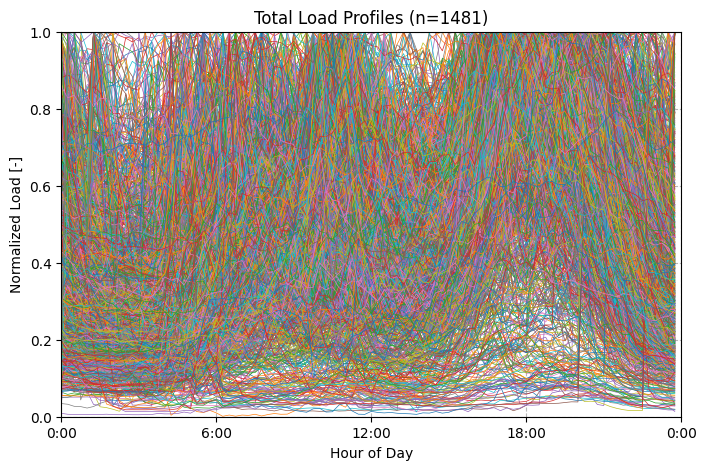

<Figure size 8000x5000 with 0 Axes>

In [26]:
labels = ['0:00','6:00','12:00','18:00','0:00']

# Annahme: data_3d hat die Form (1481, 96, 1)
# Wir extrahieren die 2D-Matrix (1481, 96) und transponieren sie zu (96, 1481)
# Matplotlib plottet jede Spalte als eigene Linie
all_curves = data_3d[:, :, 0].T 

plt.figure(figsize=(8, 5))

# Plot aller Linien auf einmal
# alpha=0.05 sorgt dafür, dass man Cluster/Häufungen erkennt (Heatmap-Effekt)
# linewidth=0.5 hält die Darstellung fein
plt.plot(all_curves, alpha=1.0, linewidth=0.5)

# X-Achsen Formatierung (sauberer als 25 Ticks)
# Indizes für 15-Minuten Schritte: 0=0:00, 24=6:00, 48=12:00, etc.
tick_positions = [0, 24, 48, 72, 96]
tick_labels = ['0:00', '6:00', '12:00', '18:00', '0:00']

plt.xticks(ticks=tick_positions, labels=tick_labels)
plt.xlabel('Hour of Day')
plt.ylabel('Normalized Load [-]')
plt.title(f'Total Load Profiles (n={all_curves.shape[1]})')

plt.xlim(0, 96)
plt.ylim(0, 1)
plt.grid(True, which='major', linestyle='--', alpha=0.9)
plt.figure(figsize=(8, 5), dpi=1000) 
plt.tight_layout()
plt.show()